In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
from IPython.display import HTML
import os
import urllib.request
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geopandas as gdf
from shapely.geometry import Point
import datetime
import geopy
import geopy.distance
import seaborn as sns
from geopandas import GeoDataFrame
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
from itertools import compress
from sklearn.cluster import KMeans
import csv

#TO DO
Write a text intro
Clean notebook
Add an "open in colab" button
Get url download link for original csvs.

*   Write a text intro
*   Clean notebook
*   Add an "open in colab" button
*   Get url download link for original csvs.List item



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/MyDrive/colab/')

Note, if working from the Zenodo repository, set the working directory to the "raw_data" folder. Outputs from this script can be found in the "analysis_data" folder.

In [ ]:
a =pd.read_csv('pipeline_failures_storm.csv')
a.DATE = pd.to_datetime(a.DATE)

<ipython-input-5-905c6d06a08c>:1: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  a =pd.read_csv('pipeline_failures_storm.csv')


In [ ]:
a['yr'] = a['DATE'].dt.year

The column 'diftime' will have an nan (not a number) value anytime no hurricanes have come within 300 miles of the fail point.

In [ ]:
b = a.dropna(subset=['diftime'])
b.shape

(9742, 45)

In [ ]:
a = None

In [ ]:
#NOAHURDAT Data
# Can we pull this directly from an internet url?

hur  = pd.read_excel("NOAAHURDAT.xlsx",engine='openpyxl')
hur = hur.sort_values(['date'])
hur = hur.sort_values(['start_date'])
hur = hur.sort_values(['end_date'])
hur['dateTime'] = hur['start_date'].astype(str).str.cat(hur['time'].astype(str),sep=" ")
hur['dateTime'] = pd.to_datetime(hur['dateTime'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
hur.name = hur.name.astype('category')

#Create merged PHMSA + HURDAT 2 dataset




Use the "HurIDX" column to idenfy hurdat points already affiliated with failures


In [ ]:
b.HurIdx

485          7
580          7
730         76
748         76
754         76
         ...  
24957    12101
24961    12074
24964    12073
24965    12101
24967    12102
Name: HurIdx, Length: 9742, dtype: int64

In [ ]:
hur = hur[~hur['Unnamed: 0'].isin(b.HurIdx[b.diftime<60].unique())]
hur.shape

(11643, 21)

In [ ]:
b.category = np.nan

In [ ]:
test = pd.concat([b, hur], ignore_index=False)


In [ ]:
b = None

Use the pipeline failure latitude column to identify wherther or not storm is associated with failure

In [ ]:
test.category.unique()

array([nan, -1.,  0.,  1.,  3.,  2.,  4.,  5.])

In [ ]:
test['failTF'] = np.nan

In [ ]:
test['failTF'][np.isnan(test.LATITUDE)] = 0
test['failTF'][~np.isnan(test.LATITUDE)] = 1

Assign the hurricane failure year to entries with no failure (and therefore no failure year)

In [ ]:
test.yr[np.isnan(test.yr)] = test['year'][np.isnan(test.yr)]

In [ ]:
test['DATE'] = pd.to_datetime(test['DATE'])#, errors='coerce')
test.month = test['DATE'].dt.month
test.name[(test.name=="0") & (test.month.isin([1,2,3,4,5,6]))]="NoStorm"

In [ ]:
test.size

983710

In [ ]:
#remove all rows with "0" values in the "name" column
test = test[test.name != "0"]

In [ ]:
test.size

832784

In [ ]:
test['yr'] = test['yr'].astype('str')
test['name'] = test['name'].astype('str')
test['name'] = test['name'] + test['yr']
test['name'] = test.name.str.split('.').str[0]

In [ ]:
test['yr'] = test['yr'].astype('category')
test['name'] = test['name'].astype('category')

In [ ]:
np.unique(test.name)

array(['AL0119931993', 'AL0120002000', 'AL0219921992', 'AL0219941994',
       'AL0219991999', 'AL0220002000', 'AL0220012001', 'AL0220032003',
       'AL0220062006', 'AL0319871987', 'AL0319921992', 'AL0419911991',
       'AL0420002000', 'AL0519941994', 'AL0619881988', 'AL0619951995',
       'AL0619971997', 'AL0620032003', 'AL0719991999', 'AL0720022002',
       'AL0720032003', 'AL0819921992', 'AL0819941994', 'AL0919941994',
       'AL0920002000', 'AL0920012001', 'AL0920032003', 'AL1019911991',
       'AL1019931993', 'AL1019941994', 'AL1020042004', 'AL1119991999',
       'AL1219911991', 'AL1219991999', 'AL1419951995', 'AL1420022002',
       'AL1420032003', 'Al2020112011', 'Alberto1982', 'Alberto1988',
       'Alberto1994', 'Alberto2000', 'Alberto2006', 'Alberto2012',
       'Alberto2018', 'Alex1998', 'Alex2004', 'Alex2010', 'Alex2016',
       'Alicia1983', 'Allison1989', 'Allison1995', 'Allison2001',
       'Amelia1978', 'Amy1975', 'Ana1979', 'Ana1985', 'Ana1991',
       'Ana1997', 'Ana20

In [ ]:
test['ptlat']=np.nan
test['ptlong']=np.nan

In [ ]:
hurf = hur
hurf['year'] = hurf['year'].astype('str')
hurf['name'] = hurf['name'].astype('str')

hurf['name'] = hurf['name'] + hurf['year']

In [ ]:
minlat = hurf[['lat','name']].groupby(by = "name").min()
minlat = minlat.rename(columns={"lat": "minlat"})

minlon = hurf[['long','name']].groupby(by = "name").min()
minlon = minlon.rename(columns={"long": "minlong"})

In [ ]:
hurf = None
hur = None

In [ ]:
test = pd.merge(test, minlon, left_on='name', right_on = "name", how="left" )
test = pd.merge(test, minlat, left_on='name', right_on = "name", how="left" )

In [ ]:
test.columns

Index(['Unnamed: 0.1', 'PipeIDX', 'Unnamed: 0', 'CAUSE', 'DATE',
       'INCIDENT_CITY', 'INCIDENT_COUNTY', 'INCIDENT_STATE', 'ZIP_CODE',
       'INSTALLATION_YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MANYR',
       'TYPE', 'ITMYR', 'year', 'Point', 'PipeIdx', 'name', 'month', 'day',
       'hour', 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter', 'DATETIME1',
       'date', 'start_date', 'time', 'pointh', 'end_date', 'dateTime',
       'HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF', 'ptlat', 'ptlong', 'minlong', 'minlat'],
      dtype='object')

In [ ]:
test.wind[test.wind==0]=12
test.pressure[test.pressure==0]=1050
test.minlat[test.minlat.isnull()]=float(minlat.max())
test.minlong[test.minlong.isnull()]=float(minlon.min())

<ipython-input-35-dc0a269f84fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.wind[test.wind==0]=12
<ipython-input-35-dc0a269f84fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.pressure[test.pressure==0]=1050
<ipython-input-35-dc0a269f84fa>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test.minlat[test.minlat.isnull()]=float(minlat.max())
<ipython-input-35-dc0a269f84fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

In [ ]:
test.minlong.isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
18099    False
18100    False
18101    False
18102    False
18103    False
Name: minlong, Length: 18104, dtype: bool

In [ ]:
#test.pressure = test.pressure *-1

In [ ]:
test.CAUSE[test.CAUSE == 'DAMAGE BY OUTSIDE FORCES']='outside'
test.CAUSE[test.CAUSE == 'CONSTRUCTION DEFECT/MATERIAL FAILURE']='outside'
test.CAUSE[test.CAUSE == 'CORROSION']='outside'
test.CAUSE[test.CAUSE == 'OTHER']='outside'
test.CAUSE[test.CAUSE == 'CONSTRUCTION/OPERATING ERROR']='human'
test.CAUSE[test.CAUSE == 'DAMAGE BY OUTSIDE FORCE']='outside'
test.CAUSE[test.CAUSE == 'CONSTRUCTION/MATERIAL DEFECT']='outside'
test.CAUSE[test.CAUSE == 'ACCIDENTALLY CAUSED BY OPERATOR']='outside'
test.CAUSE[test.CAUSE =='OUTSIDE FORCE DAMAGE']='outside'
test.CAUSE[test.CAUSE =='FAILED PIPE']= 'outside'
test.CAUSE[test.CAUSE =='FAILED WELD']='outside',
test.CAUSE[test.CAUSE == 'MALFUNCTION OF CONTROL OR RELIEF EQUIPMENT']= 'outside'
test.CAUSE[test.CAUSE =='INCORRECT OPERATION BY OPERATOR PERSONNEL']= 'human'
test.CAUSE[test.CAUSE =='EXCAVATION DAMAGE']='human'
test.CAUSE[test.CAUSE =='OTHER OUTSIDE FORCE DAMAGE']='outside'
test.CAUSE[test.CAUSE =='INCORRECT OPERATION']= 'human'
test.CAUSE[test.CAUSE =='MATERIAL AND/OR WELD FAILURES']='outside'
test.CAUSE[test.CAUSE == 'EQUIPMENT']='outside'
test.CAUSE[test.CAUSE =='NATURAL FORCES']='natural'
test.CAUSE[test.CAUSE =='EQUIPMENT FAILURE']='outside'
test.CAUSE[test.CAUSE =='CORROSION FAILURE']='outside'
test.CAUSE[test.CAUSE =='MATERIAL FAILURE OF PIPE OR WELD']='outside'
test.CAUSE[test.CAUSE =='NATURAL FORCE DAMAGE']= 'natural'
test.CAUSE[test.CAUSE =='OTHER INCIDENT CAUSE']='outside'


<ipython-input-37-8a6087fcc35a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.CAUSE[test.CAUSE == 'DAMAGE BY OUTSIDE FORCES']='outside'
<ipython-input-37-8a6087fcc35a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.CAUSE[test.CAUSE == 'CONSTRUCTION DEFECT/MATERIAL FAILURE']='outside'
<ipython-input-37-8a6087fcc35a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.CAUSE[test.CAUSE == 'CORROSION']='outside'
<ipython-i

In [ ]:
test.CAUSE=test.CAUSE.astype('category')
test.CAUSE.unique()

['outside', 'human', 'natural', NaN]
Categories (3, object): ['human', 'natural', 'outside']

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<ipython-input-39-1902369eb8ba>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [ ]:
N_a= world.loc[world['name'] == 'United States of America']
N_a_p= world.loc[world['continent'] == 'North America']

In [ ]:
world = None

In [ ]:
gdf = gpd.GeoDataFrame(
    test, geometry=gpd.points_from_xy(test.ptlong, test.ptlat), crs="EPSG:4326"
)

In [ ]:
#N_a = N_a.to_crs()
gdfclip = gpd.clip(gdf, N_a.buffer(0.35))
gdfclip.shape

In [ ]:
sum(test.failTF)

6461.0

In [ ]:
gdfclip[gdfclip.failTF==1].shape

(6342, 51)

In [ ]:
gdfclip.columns

Index(['Unnamed: 0.1', 'PipeIDX', 'Unnamed: 0', 'CAUSE', 'DATE',
       'INCIDENT_CITY', 'INCIDENT_COUNTY', 'INCIDENT_STATE', 'ZIP_CODE',
       'INSTALLATION_YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MANYR',
       'TYPE', 'ITMYR', 'year', 'Point', 'PipeIdx', 'name', 'month', 'day',
       'hour', 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter', 'DATETIME1',
       'date', 'start_date', 'time', 'pointh', 'end_date', 'dateTime',
       'HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF', 'ptlat', 'ptlong', 'minlong', 'minlat', 'geometry'],
      dtype='object')

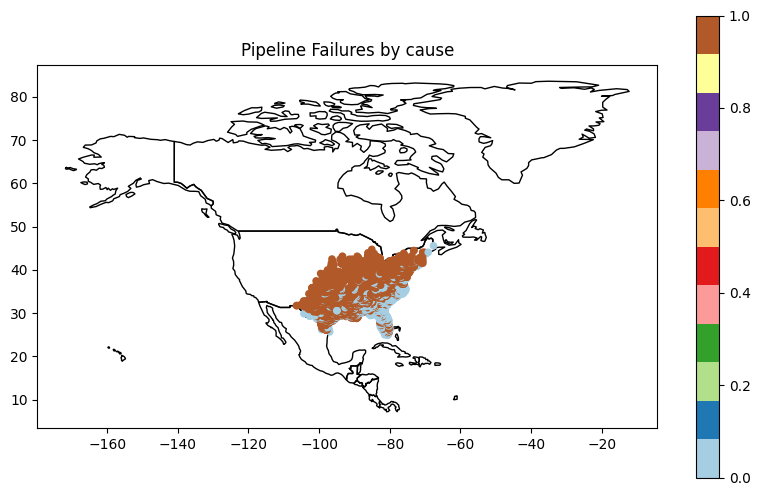

In [ ]:
f, ax1 = plt.subplots(figsize=(10, 6))
N_a_p.plot(ax=ax1,facecolor="none", edgecolor='black',)
gdfclip.plot(ax=ax1,
            column=gdfclip.failTF, cmap='Paired',
            markersize=20, legend= True
           )

#overlap.plot(ax=ax1, color='black',
#                markersize=50
#                )

ax1.set(title="Pipeline Failures by cause")
plt.show()

In [ ]:
np.random.seed(0)
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(gdfclip[['ptlat', 'ptlong']])
gdfclip['locGrp']=kmeans.predict(gdfclip[['ptlat', 'ptlong']])
gdfclip.locGrp=gdfclip.locGrp.astype('category')

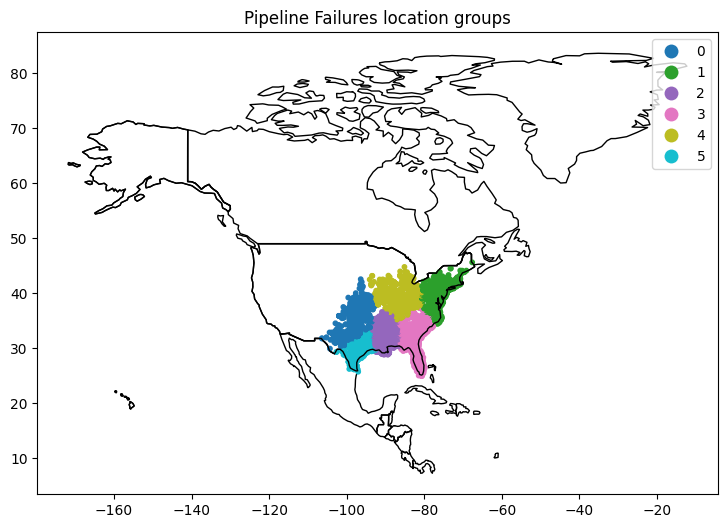

In [ ]:
# Format and plot your results from task 2
# Format and plot your results from task 2
f, ax1 = plt.subplots(figsize=(10, 6))
N_a_p.plot(ax=ax1,facecolor="none", edgecolor='black',)
gdfclip.plot(ax=ax1,
            column=gdfclip.locGrp,cmap="tab10",
            markersize=10, legend= True
           )

N_a.plot(ax=ax1,facecolor="none", edgecolor='black',)

ax1.set(title="Pipeline Failures location groups")
plt.show()


## Save binomial fail Y/N merge

In [ ]:
binom = gdfclip[["PipeIDX", "CAUSE", "LATITUDE", "LONGITUDE", "yr", 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter','HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF', 'locGrp', 'ptlong', 'ptlat', 'minlong','minlat']]

In [ ]:
binom.to_csv("analysis_ready_binomial.csv")

In [ ]:
binom = None

In [ ]:
test = None

##Part 2: Frequency data

Frequency counts for mixed effects model:


In [ ]:
#Collapse dataframe
ard = gdfclip[['INSTALLATION_YEAR','name','lat', 'long', 'status', 'category', 'wind', 'pressure', 'tropicalstorm_force_diameter', 'hurricane_force_diameter','date', 'yr', 'failTF','locGrp', 'ptlong', 'ptlat', 'minlong','minlat']]

In [ ]:
gdfclip = None

In [ ]:
ard.locGrp = ard.locGrp.astype('category')
ard.name = ard.name.astype('category')
ard.yr = ard.yr.astype('category')

In [ ]:
ard1 =ard[['name','locGrp', 'yr','category','wind','pressure',  "minlong",'ptlat','failTF', 'minlat', 'ptlong']].groupby(by=['name', 'locGrp','yr']).agg(
    {'ptlat': ['mean'], 'ptlong': ['mean'], 'wind':['max'], 'pressure':['min'], 'minlong':['min'], 'minlat':['min'], 'failTF':['sum']}).reset_index()
ard1 = ard1.dropna()
ard1.columns = ['name','locGrp', 'yr','ptlat_mean', 'ptlong_mean', 'wind_max', 'pressure_min', 'minlong_min', 'minlat_min','failTF_sum']
ard1.head()

,name,locGrp,yr,ptlat_mean,ptlong_mean,wind_max,pressure_min,minlong_min,minlat_min,failTF_sum
161,AL0219921992,3,1992.0,28.500000,-82.900000,30.0,1007.0,-85.5,24.5,0.0
451,AL0219941994,3,1994.0,33.775000,-79.750000,30.0,1015.0,-81.0,32.2,0.0
499,AL0219941994,4,1994.0,38.609196,-81.405919,20.0,1016.0,-81.0,32.2,1.0
588,AL0319871987,0,1987.0,33.006273,-96.539115,30.0,1009.0,-94.0,26.3,1.0
684,AL0319871987,2,1987.0,31.375636,-89.098491,40.0,1007.0,-94.0,26.3,2.0


In [ ]:
ard1.shape

(602, 10)

In [ ]:
ard1.to_csv("analysis_ready.csv")